In [1]:
from mimic.utilities.utilities import *
from mimic.model_infer.infer_gLV_bayes import *

from mimic.model_infer import *
from mimic.model_simulate import *
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Comparison of ridge vs lasso regression

### Five species, single time course. 
Note that perturbation not currently implemented in multi penalty lasso

Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: [[0.0], [-1.0], [0.0], [-1.0], [0.0]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': [[0.0], [-1.0], [0.0], [-1.0], [0.0]]}
n: 245, p: 30


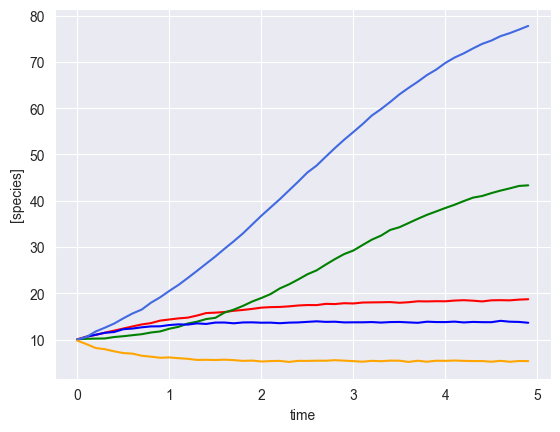

In [9]:
## Don't use epsilon here so can remove and just use function in line below to generate data??

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

epsilon = [[0.],
           [-1.],
           [0.],
           [-1.],
           [0.]]

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu,
                    epsilon=epsilon)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, y0, mu, M, _ = simulator.simulate(times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

# linearise
X, F = linearize_time_course_16S(yobs, times)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

(5,)
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: []
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}


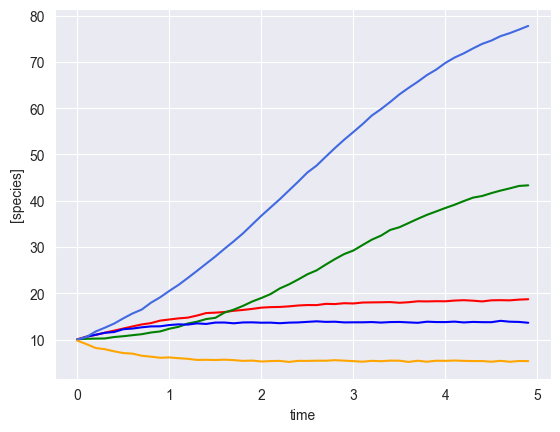

In [2]:
# Generate simulated 5 species data and plot it
# Return growth rate matrix (mu), interaction matrix (M), times and simulated results with Gaussian noise incorporated (yobs)

sim_gLV_class = sim_gLV()
yobs, times, mu, M = generate_5_species_data(sim_gLV_class)

In [5]:
# linearise
num_species = F.shape[1]
X, F = linearize_time_course_16S(yobs, times)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

n: 245, p: 30


### Perform ridge regression

minimum found: a0/a1/error: 0.04281332398719394 1.8329807108324375e-05 0.10392580626764218
unconstrained error        : 0.10622696904823237
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [4.243139743559434, 1.6871874501424389, 4.546734537790988, 0.2892014481585091, 14.868988143024334], 'M': [[-0.3179789035693272, -0.1355114219024468, 0.05750010726175775, 0.09239401844353518, -0.07453732148701936], [-0.16482927929236077, -0.1874693249091006, 0.08563334204762506, 0.1086676747819508, -0.003462522833909557], [0.2403259032305828, 0.10447532361583635, -0.5123603413870749, -0.07219213432174712, -0.16454370564953413], [0.0918920692672096, 0.06144225826305407, -0.04376156508495014, -0.050067089325330716, -0.015899051046201484], [-0.190617673869798, -0.11707219821260309, -0.5939552180968085, 0.07941196463720927, -0.7820101058285958]], 'epsilon': array([], shape=(5, 0), dtype=float64)}
mu_hat/mu:
[ 4.24313974  1.68718745  4.54673454  0.28920145 14.86898814]
[1.2785384

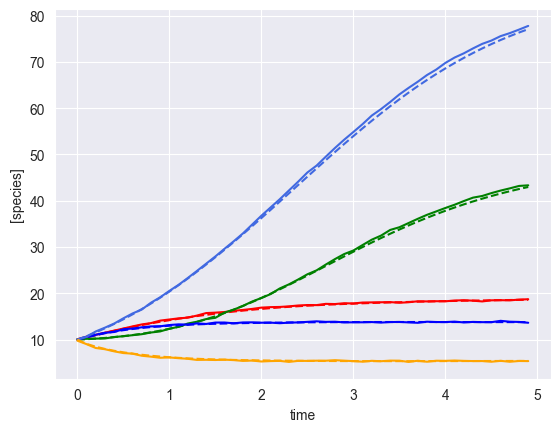

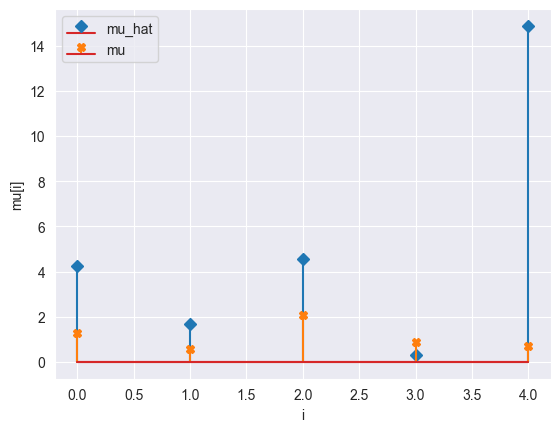

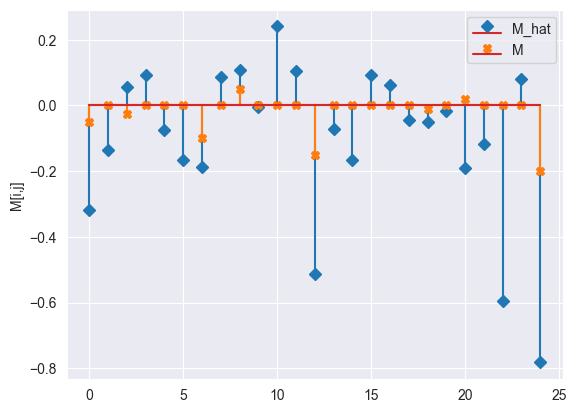

In [7]:
init_species = 10 * np.ones(num_species)

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0=a0, a1=a1)

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h)

yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

### Fit same data with the multi-penalty lasso

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


minimum found: a/error: [7.74263683e-05 7.74263683e-05] 0.10230403941174793
mu_hat/mu:
[ 2.3133843   0.          2.64126638  0.         13.90722046]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.27 -0.11  0.12  0.07  0.  ]
 [-0.12 -0.16  0.14  0.09  0.06]
 [ 0.32  0.15 -0.48 -0.1  -0.1 ]
 [ 0.1   0.06 -0.03 -0.05 -0.  ]
 [-0.14 -0.09 -0.59  0.06 -0.75]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [2.3133843043621245, 0.0, 2.6412663799457503, 0.0, 13.907220463196968], 'M': [[-0.271303451261259, -0.1085211422158094, 0.12256506877840663, 0.07425247560258405, 0.0], [-0.12030452140754683, -0.16192060367772518, 0.1392336890288673, 0.0914894467980668, 0.06055048395159961], [0.31953452027159607, 0.1478886765880609, -0.4780961735927366, -0.10145860

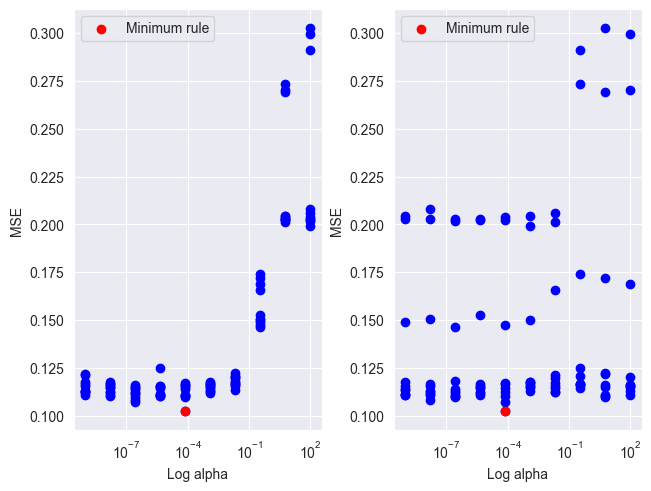

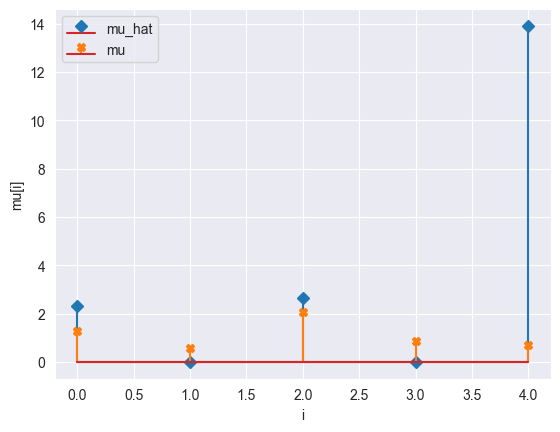

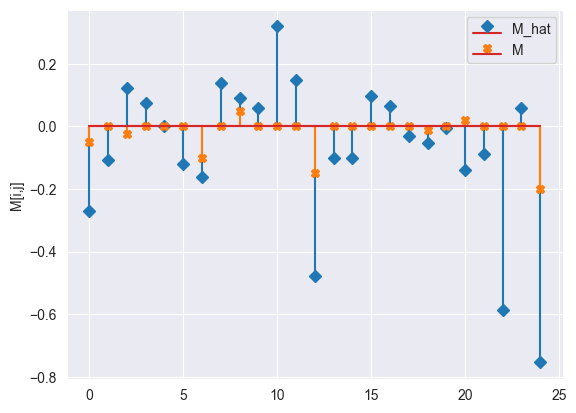

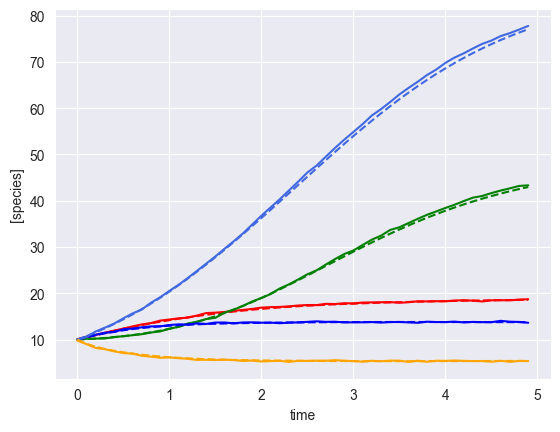

In [8]:
# F = dlnX/dt
DlnX = np.diff(np.log(yobs), axis=0)
Dt = np.tile(np.diff(times), (num_species, 1))
F = np.divide(DlnX, np.transpose(Dt))

# X matrix: stacked observed counts
mX = np.vstack([np.transpose(yobs), np.ones(len(times))])
tX = np.transpose(mX[:, :-1])

alphas = fit_alpha_MPLasso(tX, F, 10)

alpha = np.append(np.ones(num_species)*alphas[0], alphas[1])
model = MultiPenaltyLasso(alpha=alpha)
model.fit(tX, F)

mu_h = [model.coef_[i][-1] for i in range(0, num_species)]
M_h = [model.coef_[i][:num_species].tolist() for i in range(0, num_species)]

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

rho = 100

# get prediction
predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h)

yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, times)